# UAV Audio Recognition
UAV Audio Recognition - ver. 20210824

Features:
1. Mel-spectrogram
2. Cifar10-network 
3. Iphone-dataset 
4. Binary output of UAV prediction 


## 1. Model Training Environment Setup

Runtime: GPU preferred

Library needed:
1. Tensorflow-io: provides useful extra Dataset, streaming, and file system extensions, such as audio file propessing  
2. Tensorflow 


In [1]:
pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 16 kB/s 
     |████████████████████████████████| 2.3 MB 34.1 MB/s 


In [2]:
# testing for GPU (GPU測試)

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# listing Devices (列出設備)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13813362264418431583, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9281500707371459941
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
import os
import pathlib
import librosa

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from kapre import STFT, Magnitude, MagnitudeToDecibel
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer


print(tf.__version__)

# Set seed for experiment reproducibility
seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

2.6.0


## 2. Import the Dataset from drive

In [5]:
# Skip this step when running in local
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = pathlib.Path('/content/drive/MyDrive/UAV/Dataset/5000')

1. Check basic statistics about the dataset.

2. Convert the sterio files in mono files in Audacity or by the "audio pre-propessing python file"

3. Before importing the audio files, make sure that the audio data is in uniform format: 

> 1. 1 second duration
2. 44100 Hz
3. 16 bits PCM
4. wav file

4. A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time.

5. In a 16-bit system, the values range from -32768 to 32767. 

6. The sample rate for this dataset is 44.1kHz.


In [7]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['UAV' 'NO_UAV']


Extract the audio files into a list and shuffle it.

In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#important step
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0:9])

Number of total examples: 10000
Number of examples per label: 5000
Example file tensor: tf.Tensor(
[b'/content/drive/MyDrive/UAV/Dataset/5000/NO_UAV/1931.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/NO_UAV/2530.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/UAV/1591.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/NO_UAV/208.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/NO_UAV/1479.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/NO_UAV/3496.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/UAV/2819.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/UAV/4809.wav'
 b'/content/drive/MyDrive/UAV/Dataset/5000/UAV/1514.wav'], shape=(9,), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

Example:



> If there are 900 files, first, divide 10, = 90.  


> Train is 80% , 90 X 8 = 720.


> Val is 10% , 90.


> Test is 10%, 90.

In [9]:
train_files = filenames[:8000]
val_files = filenames[8000: 8000 + 1000]
test_files = filenames[-1000:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 8000
Validation set size 1000
Test set size 1000


## 3. Reading audio files and their labels

1. The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

2. Using the tf.io library is different to librosa library. tf.io will convert the audio data to the tensor, then propessing the spectrogram. librosa will process the audio data directly to spectrogram. It is a irreversible step that cannot using the librosa to make the spectrogram first and chaning into the tensor. So, the tf.io is the only solution.   

3. To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

4. `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0]. It is totally different to the one-hot encoding method. 

In [10]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [12]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Apply `process_path` to build your training set to extract the audio-label pairs and check the results. 

The validation and test sets will be built using a similar procedure later on.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

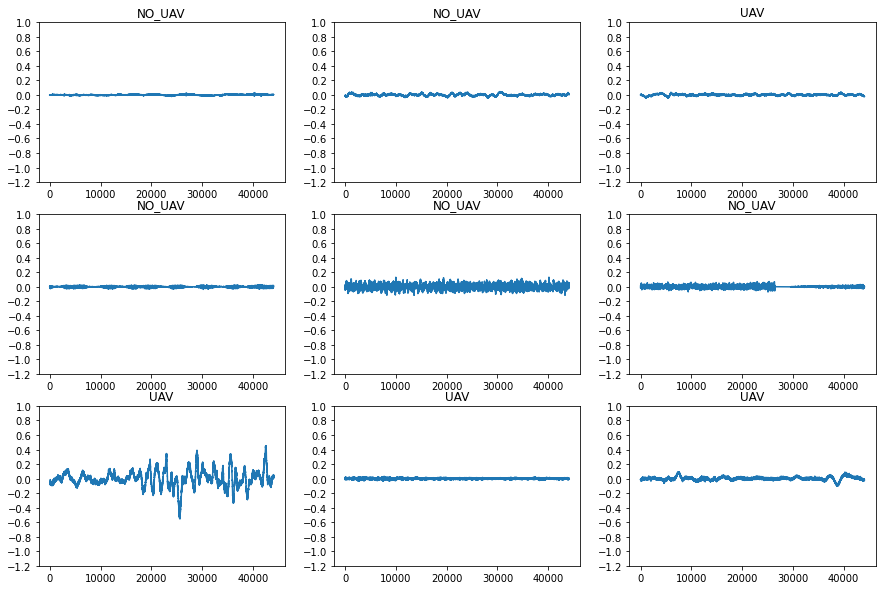

In [14]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % rows
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## 4. Spectrogram

1. Convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. 

2. Applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

3. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

4. STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

5. Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.  

6. You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second. However, all the dataset are chunked into 1 seconds. 

Note: 做STFT时每次取出的一段信号，叫做一帧(frame)。每两帧之间的间隔为Hop Size，一般为frame长度的25%-75%。将对每一帧做DFT得到的结果拼接到一起，可以得到spectrogram。增加frame的长度，频域的信息会越准确。https://zhuanlan.zhihu.com/p/351634228


In [15]:
import tensorflow as tf
import tensorflow_io as tfio

In [16]:
def get_spectrogram(waveform):
  # Padding for files with less than 44100 samples
  zero_padding = tf.zeros([44100] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=2048, frame_step=129)

  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(spectrogram, rate=44100, mels=128, fmin=0, fmax=22050)
  spectrogram = mel_spectrogram

  return spectrogram

In [17]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Examine one of the data in the dataset. 

Label: NO_UAV
Waveform shape: (44100,)
Spectrogram shape: (326, 128)
Audio playback


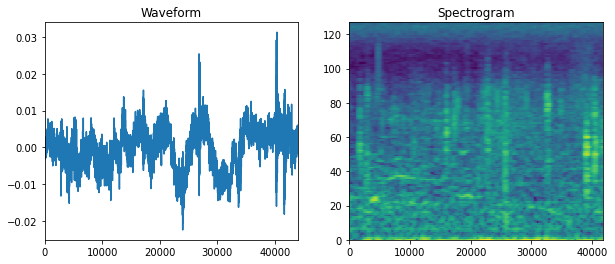

In [18]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 44100])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
#axes[1].set_xlim([0, 44100])
#axes[1].set_ylim([0, 128])
plt.show()

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

## 5. Dataset mapping

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [19]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [20]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

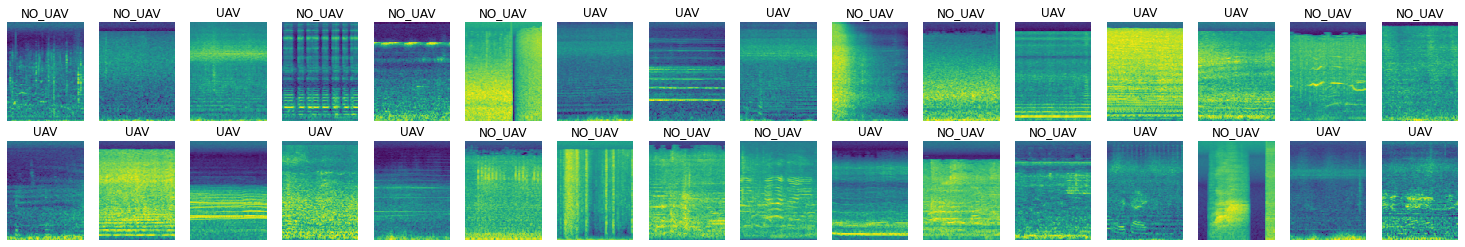

In [21]:
rows = 2
cols = 16
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(26, 4))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## 6. Build the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [22]:
# After changing the hyper parameter, start from here.

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [23]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [24]:
# Changing the batch size here (16, 32, 64)
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [25]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### Cifar10 

https://github.com/chen0040/keras-audio

The classifer model used the Cifar10Audio Classifier.

The training accuracy reached over 80% after 29 epochs.

The training accuracy reached over 90% after 38 epochs.

The training accuracy after 100 epochs is 98.13%, with validation accuracy of 71%.

https://github.com/chen0040/keras-audio/blob/master/keras_audio/library/cifar10.py

<img src = "https://github.com/chen0040/keras-audio/raw/master/demo/models/training-history-comparison.png
" width = "400" />


<img src = "https://miro.medium.com/max/768/1*chbylvv0Lts1hKEuOJix6g.png
" width = "400" />


In [26]:
pip install lru-dict

  Created wheel for lru-dict: filename=lru_dict-1.1.7-cp37-cp37m-linux_x86_64.whl size=28405 sha256=61b4956e2be57abddacc135dd9f91701298fc68a759a190084e1f94525cbd9b9
  Stored in directory: /root/.cache/pip/wheels/9d/0b/4e/aa8fec9833090cd52bcd76f92f9d95e1ee7b915c12093663b4
Successfully built lru-dict


In [27]:
from keras.callbacks import ModelCheckpoint
from lru import LRU
import keras.backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

channel_axis = 3
freq_axis = 1
time_axis = 2

Input shape: (326, 128, 1)


For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [ ]:
#input layer of the model have one resizing and normalization layer
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='elu'),
    layers.Conv2D(64, 3, activation='elu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1),
])
# using the keras model add function to model the network rather than apply the orginal cifar10 network as transferring learing

model.add(Activation('sigmoid'))

# in this neutral network model, the output layer is "1" and the activiation function is "sigmoid"
# in the predictor, it just need to use the model predict function to call the percentage output
# it is a pure binary question, and the interpretation of the output is ...
# 0 is "uav" and 1 is background, using the "print (commands[1])" function to verify the answer and  #commands[1] is background.
# 0.5 means it cannot predict the answer effectively. 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

### Feature of the Network Model Algorithm Design

1. For the conventional binary classification problems, the final result can only be one of the two classifications, then "binary_crossentropy" is the loss function.

2. Softmax outputs two values, (e.g: 0.9 & 0.1 )which add to one. Sigmoid also outputs 2 values, (e.g: 0.9 & 0.6 ) but there is no additivity. Both values are a number from 0 to 1.

3. Currently, the drone detection is not a simple binary classification problem. Most audio files are drone sounds mixed with common background noise.

4. In this case, the audio should be classified both as "drone" and "background". However, using softmax as the activation function, the network model will classify the audio as "drone" or "background" and cannot accurately describe the situation.

5. Acturally, it is a binary multi-label classification problem. Therefore, sigmoid will be used to check each probability of the directory.

<img src = "https://glassboxmedicine.files.wordpress.com/2019/05/one-more-example.png?w=616" width = "600" />

6. If model’s output classes are NOT mutually exclusive and you can choose many of them at the same time, use a sigmoid function on the network’s raw outputs.


## 7. Train the model

1. 當處理二分類問題時使用BinaryCrossentropy
對於每一個樣本的預測值都應該是浮點型的數值（浮動）
2.當涉及到兩個或者更多個標籤類別的時候使用CategoricalCrossentropy損失函數。標籤應該以one_hot的形式被提供。
3.如果想將標籤表示為可能類型，請使用SparseCategoricalCrossentropy損失函數。

In this model, BinaryCrossentropy is selected to be loss function. 

In [ ]:
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy'],
)

In [ ]:
# observe the accuracy to avoid over-fitting

EPOCHS = 15
r1 = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,  
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
243/243 [==============================] - 1482s 6s/step - loss: 0.4183 - accuracy: 0.8038 - val_loss: 0.3333 - val_accuracy: 0.8472
Epoch 2/10
243/243 [==============================] - 3s 13ms/step - loss: 0.2972 - accuracy: 0.8699 - val_loss: 0.2835 - val_accuracy: 0.8832
Epoch 3/10
243/243 [==============================] - 3s 13ms/step - loss: 0.2384 - accuracy: 0.8983 - val_loss: 0.2376 - val_accuracy: 0.8971
Epoch 4/10
243/243 [==============================] - 3s 13ms/step - loss: 0.2095 - accuracy: 0.9108 - val_loss: 0.2132 - val_accuracy: 0.9120
Epoch 5/10
243/243 [==============================] - 3s 13ms/step - loss: 0.1858 - accuracy: 0.9234 - val_loss: 0.1864 - val_accuracy: 0.9208
Epoch 6/10
243/243 [==============================] - 3s 13ms/step - loss: 0.1533 - accuracy: 0.9374 - val_loss: 0.1678 - val_accuracy: 0.9326
Epoch 7/10
243/243 [==============================] - 3s 13ms/step - loss: 0.1425 - accuracy: 0.9430 - val_loss: 0.1674 - val_accuracy: 0.939

Let's check the training and validation loss curves to see how your model has improved during training.

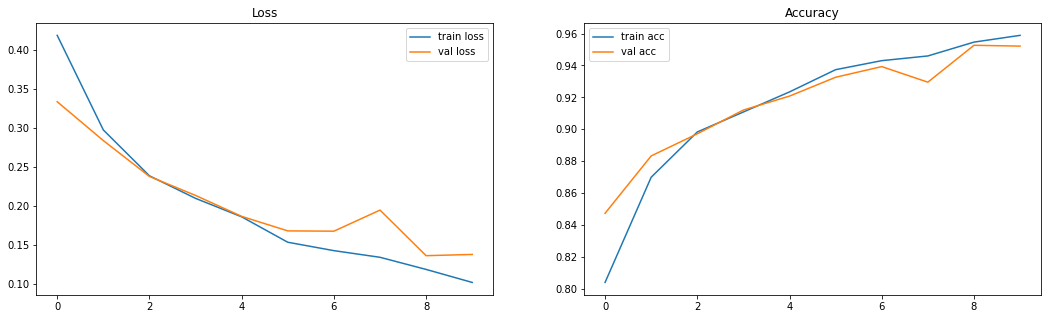

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
# plot the loss & accuracy
axes[0].set_title('Loss')

axes[0].plot(r1.history['loss'], label='train loss')
axes[0].plot(r1.history['val_loss'], label='val loss')
axes[0].legend()

# plot the accuracy
axes[1].set_title('Accuracy')
axes[1].plot(r1.history['accuracy'], label='train acc')
axes[1].plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')
plt.savefig('LossVal_loss')


## Evaluate test set performance

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(test_audio)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)
y_test = test_labels
accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy_score(y_test, y_pred):.4%}')

Test set accuracy: 94.6502%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

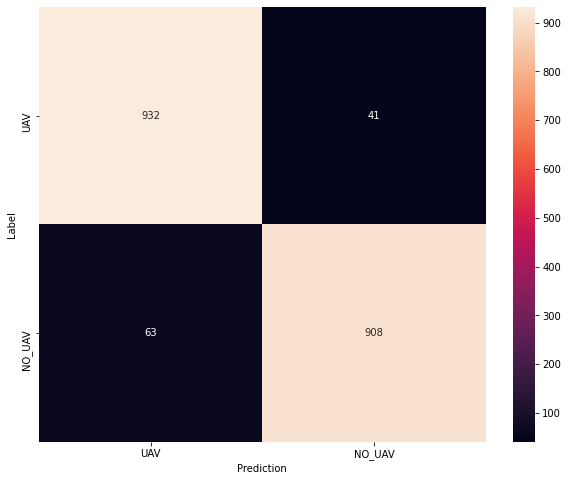

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('UAV_Audio_Recognition.h5')
# Place your model to the below path
network_path = 'UAV_Audio_Recognition.h5'
model=load_model(network_path)  

OSError: ignored

## Run inference on an audio file

Youtube dataset are used to verify the model. 

In [ ]:
import random
import matplotlib.pyplot as plt

rd = random.randint(1,1800)
print( rd ) 

path_sf = '/content/drive/MyDrive/UAV_detection/2.5hrs/NO_UAV/'

sample_file = path_sf + str(rd) + '.wav'
#print(sample_file)

display.display(display.Audio(sample_file, rate=44100))

#plot the waveform and spectrogram
audio = tfio.audio.AudioIOTensor(sample_file)
audio_slice = audio[:]
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

zero_padding = tf.zeros([44100] - tf.shape(tensor), dtype=tf.float32)
equal_length = tf.concat([tensor, zero_padding], 0)
spectrogram_1 = tf.signal.stft(equal_length, frame_length=2048, frame_step=129)
spectrogram_1 = tf.abs(spectrogram_1)
mel_spectrogram_1 = tfio.audio.melscale(spectrogram_1, rate=44100, mels=128, fmin=0, fmax=22050)
spectrogram_1 = mel_spectrogram_1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
timescale = np.arange(tensor.shape[0])
axes[0].plot(timescale, tensor.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 44100])
plot_spectrogram(spectrogram_1.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

#Prediction

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model.predict(spectrogram) 
  #plt.bar("drone", prediction[0])
  #axes[2].set_title(f'Confidence level of "Drone" detected ')
  #plt.ylim(0,1)
  if commands[label[0]] == "NO_UAV":
    print("No drone detected.")
  else:
    print(100*prediction[0][0],"% drone detected")

print(commands[label[0]])
#print(prediction.shape)
print(prediction[0][0])

112


AttributeError: ignored